In [1]:
! pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=4bb208840bc33121651ac9e4159a1e39075b1355301d0c2247277099064b67f7
  Stored in directory: /Users/nairinejla/Library/Caches/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv('AAPL.csv', sep=',', index_col=False)
df=df.drop(df.columns[0],axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.tz_localize(None)

In [ ]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-05-27,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,AAPL,2015-05-28,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,AAPL,2015-05-29,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,AAPL,2015-06-01,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,AAPL,2015-06-02,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [ ]:
df.shape

(1258, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   symbol       1258 non-null   object        
 1   date         1258 non-null   datetime64[ns]
 2   close        1258 non-null   float64       
 3   high         1258 non-null   float64       
 4   low          1258 non-null   float64       
 5   open         1258 non-null   float64       
 6   volume       1258 non-null   int64         
 7   adjClose     1258 non-null   float64       
 8   adjHigh      1258 non-null   float64       
 9   adjLow       1258 non-null   float64       
 10  adjOpen      1258 non-null   float64       
 11  adjVolume    1258 non-null   int64         
 12  divCash      1258 non-null   float64       
 13  splitFactor  1258 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(2), object(1)
memory usage: 137.7+ KB


In [ ]:
df['date'].head(5).append(df['date'].tail(5)) # to see first and last 5 rows.

0      2015-05-27
1      2015-05-28
2      2015-05-29
3      2015-06-01
4      2015-06-02
1253   2020-05-18
1254   2020-05-19
1255   2020-05-20
1256   2020-05-21
1257   2020-05-22
Name: date, dtype: datetime64[ns]

## Feature Engineering

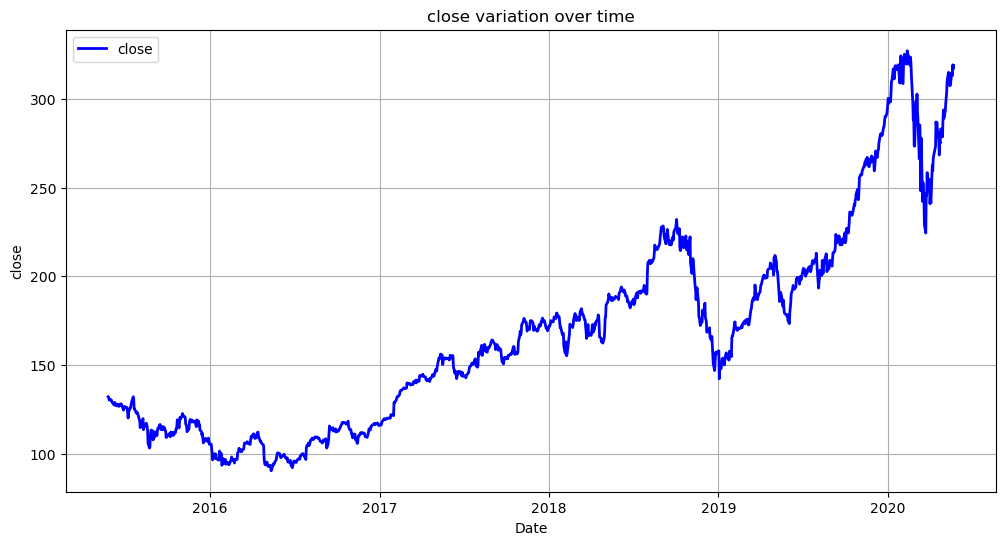

In [ ]:
# Plotting price against date
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], linewidth=2, color='b', label='close')
plt.xlabel('Date')
plt.ylabel('close')
plt.title('close variation over time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Compute RSI
df['momentum_rsi'] = RSIIndicator(close=df['close']).rsi()

# Compute MACD
macd = MACD(close=df['close'])
df['trend_macd'] = macd.macd()
df['trend_macd_signal'] = macd.macd_signal()
df['trend_macd_diff'] = macd.macd_diff()

# Compute Bollinger Bands
bollinger = BollingerBands(close=df['close'])
df['volatility_bbm'] = bollinger.bollinger_mavg()
df['volatility_bbl'] = bollinger.bollinger_lband()
df['volatility_bbh'] = bollinger.bollinger_hband()

# Compute Parabolic SAR
psar = PSARIndicator(high=df['close'], low=df['close'], close=df['close'])  # Assuming you have 'High' and 'Low' columns in your df
df['trend_psar'] = psar.psar()


# Compute Stochastic Oscillator
stochastic = StochasticOscillator(high=df['high'], low=df['low'], close=df['close'])  # Assuming you have 'High' and 'Low' columns
df['momentum_stoch'] = stochastic.stoch()
df['momentum_stoch_signal'] = stochastic.stoch_signal()

# Create Lag Features
df['Close_Lag1'] = df['close'].shift(1)

# Drop NaN values introduced due to lag features and indicators
df = df.dropna()

# Define features and target
X = df[['momentum_rsi', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'volatility_bbm', 'volatility_bbl', 'volatility_bbh', 'trend_psar', 'momentum_stoch', 'momentum_stoch_signal', 'Close_Lag1']]
y = df['close']

In [ ]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,...,trend_macd,trend_macd_signal,trend_macd_diff,volatility_bbm,volatility_bbl,volatility_bbh,trend_psar,momentum_stoch,momentum_stoch_signal,Close_Lag1
33,AAPL,2015-07-14,125.61,126.37,125.04,126.04,31768139,115.752554,116.452912,115.227286,...,-1.328825,-1.369099,0.040273,125.91275,121.997475,129.828025,126.237969,60.396975,53.213611,125.66
34,AAPL,2015-07-15,126.82,127.15,125.58,125.72,33649200,116.867598,117.171700,115.724909,...,-1.085016,-1.312282,0.227266,125.87375,122.011296,129.736204,120.070000,76.152305,65.806282,125.61
35,AAPL,2015-07-16,128.51,128.57,127.35,127.74,36222447,118.424972,118.480264,117.356005,...,-0.746818,-1.199189,0.452371,125.93425,121.948396,129.920104,120.205000,99.358289,78.635856,126.82
36,AAPL,2015-07-17,129.62,129.62,128.31,129.08,46164710,119.447863,119.447863,118.240668,...,-0.384790,-1.036309,0.651519,126.02125,121.800288,130.242212,120.537200,100.000000,91.836864,128.51
37,AAPL,2015-07-20,132.07,132.97,130.70,130.97,58900203,121.705596,122.534967,120.443109,...,0.098677,-0.809312,0.907989,126.29475,121.318025,131.271475,121.082168,93.454545,97.604278,129.62


In [ ]:
# Splitting TS data into train and test set for model training and testing
train_ts = df.iloc[0:1100,]
test_ts = df.iloc[1100: ,]

In [ ]:
# Define features and target for the training set
X_train = train_ts[['momentum_rsi', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'volatility_bbm', 'volatility_bbl', 'volatility_bbh', 'trend_psar', 'momentum_stoch', 'momentum_stoch_signal']]#, 'Close_Lag1']]
y_train = train_ts['close']
# Define features and target for the testing set
X_test = test_ts[['momentum_rsi', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'volatility_bbm', 'volatility_bbl', 'volatility_bbh', 'trend_psar', 'momentum_stoch', 'momentum_stoch_signal']]#, 'Close_Lag1']]
y_test = test_ts['close']

In [ ]:
# Initialize the model
model = xgb.XGBRegressor(
    learning_rate=0.75,
    n_estimators=400,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    gamma=0,
    min_child_weight=1
)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.75, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

y_train_pred = model.predict(X_train)

Mean Absolute Error: 38.08965943847657
Mean Squared Error: 1834.3237533544482
Root Mean Squared Error: 42.82900598139593


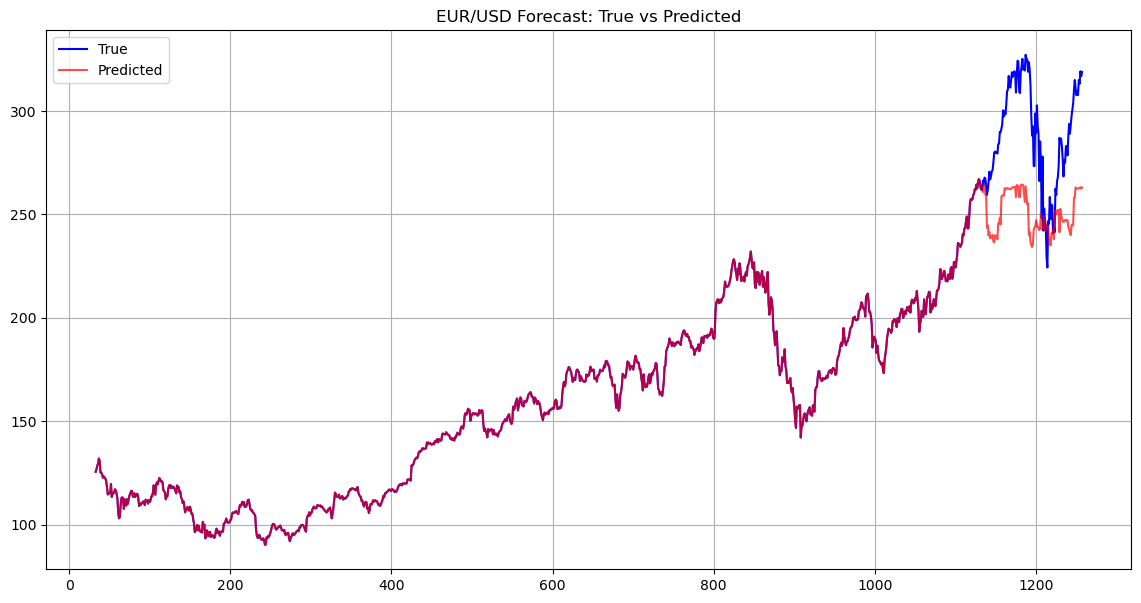

In [ ]:
# Create a new DataFrame for visualization
viz_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})

# Concatenate the training data for a complete view
viz_df_train = pd.DataFrame({'True': y_train, 'Predicted': y_train_pred})
viz_df = pd.concat([viz_df_train, viz_df])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(viz_df['True'], label='True', color='blue')
plt.plot(viz_df['Predicted'], label='Predicted', color='red', alpha=0.7)
plt.title('EUR/USD Forecast: True vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
f_importance = model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')

In [ ]:
importance_df

,0
momentum_rsi,12.319273
trend_macd,2.337742
trend_macd_signal,11.293073
trend_macd_diff,6.561201
volatility_bbm,158.039597
volatility_bbl,3107.856201
volatility_bbh,414.598297
trend_psar,113.709175
momentum_stoch,1.640026
momentum_stoch_signal,0.962046


<AxesSubplot:>

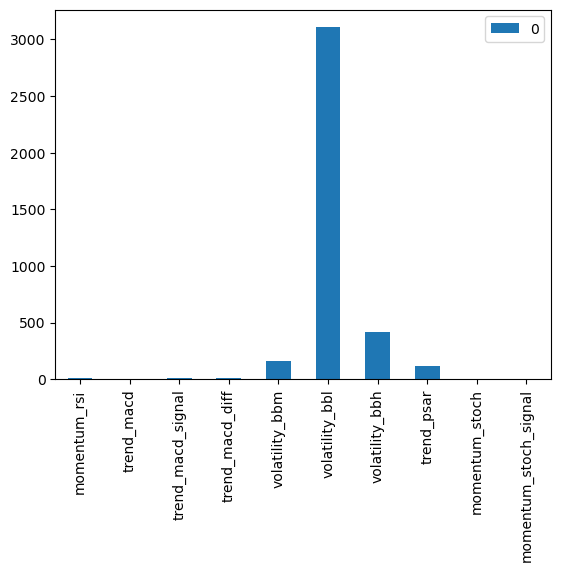

In [ ]:
importance_df.plot.bar()

In [ ]:
# Define features and target for the training set
X_train = train_ts[['trend_macd_diff', 'volatility_bbm', 'volatility_bbl', 'volatility_bbh', 'trend_psar', 'momentum_stoch_signal']]#, 'Close_Lag1']]
y_train = train_ts['close']
# Define features and target for the testing set
X_test = test_ts[['trend_macd_diff', 'volatility_bbm', 'volatility_bbl', 'volatility_bbh', 'trend_psar', 'momentum_stoch_signal']]#, 'Close_Lag1']]
y_test = test_ts['close']

In [ ]:
# Initialize the model
model = xgb.XGBRegressor(
    learning_rate=0.75,
    n_estimators=400,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    gamma=0,
    min_child_weight=1
)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.75, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

y_train_pred = model.predict(X_train)

Mean Absolute Error: 30.707566298828127
Mean Squared Error: 1330.8882472203206
Root Mean Squared Error: 36.48134108308411


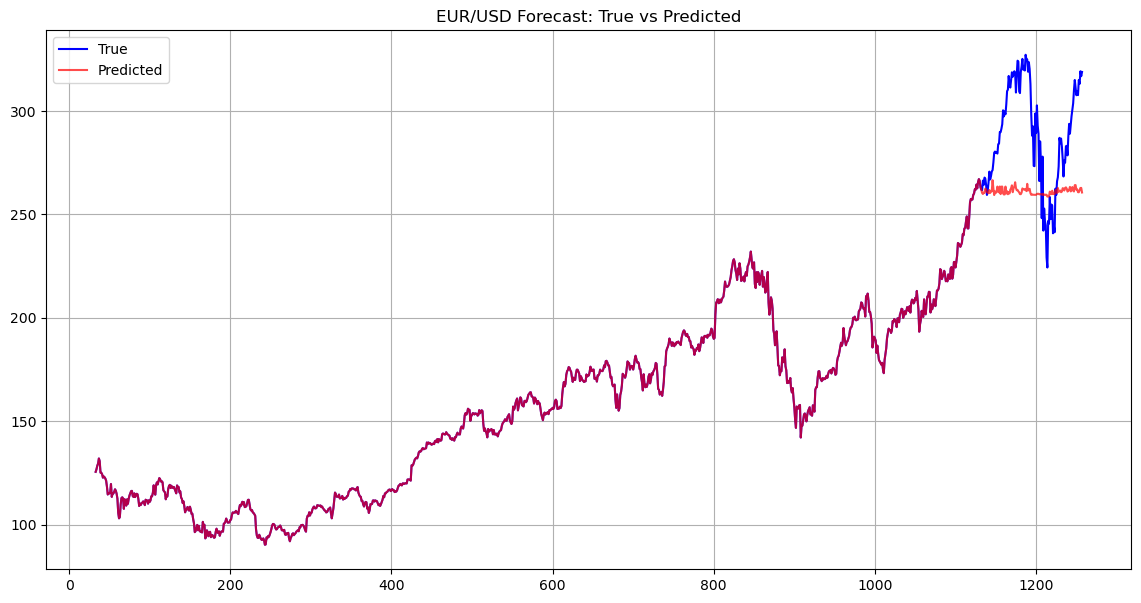

In [ ]:
# Create a new DataFrame for visualization
viz_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})

# Concatenate the training data for a complete view
viz_df_train = pd.DataFrame({'True': y_train, 'Predicted': y_train_pred})
viz_df = pd.concat([viz_df_train, viz_df])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(viz_df['True'], label='True', color='blue')
plt.plot(viz_df['Predicted'], label='Predicted', color='red', alpha=0.7)
plt.title('EUR/USD Forecast: True vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparameters tuning

In [ ]:
! pip install optuna

     -------------------------------------- 413.4/413.4 kB 1.8 MB/s eta 0:00:00
     -------------------------------------- 233.4/233.4 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 78.6/78.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 400,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2023-12-30 17:23:09,024] A new study created in memory with name: no-name-e3324936-cb93-4949-b373-4f82b62c1e6a
[I 2023-12-30 17:23:09,736] Trial 0 finished with value: 47.601918200166956 and parameters: {'learning_rate': 0.08308782100608086, 'max_depth': 10, 'subsample': 0.19108459497526464, 'colsample_bytree': 0.3595267518417576, 'min_child_weight': 10}. Best is trial 0 with value: 47.601918200166956.
[I 2023-12-30 17:23:10,403] Trial 1 finished with value: 70.3849155244722 and parameters: {'learning_rate': 0.0060441593634118825, 'max_depth': 9, 'subsample': 0.5323370160996321, 'colsample_bytree': 0.9045588290940242, 'min_child_weight': 12}. Best is trial 0 with value: 47.601918200166956.
[I 2023-12-30 17:23:11,389] Trial 2 finished with value: 40.79833802509629 and parameters: {'learning_rate': 0.011141504683174727, 'max_depth': 10, 'subsample': 0.9736345683974643, 'colsample_bytree': 0.9048644285661678, 'min_child_weight': 1}. Best is trial 2 with value: 40.79833802509629.
[I 202

[I 2023-12-30 17:23:29,722] Trial 28 finished with value: 37.40511024012783 and parameters: {'learning_rate': 0.015511293819027477, 'max_depth': 7, 'subsample': 0.7210878846281032, 'colsample_bytree': 0.6797664299409798, 'min_child_weight': 3}. Best is trial 26 with value: 36.284474691575284.
[I 2023-12-30 17:23:30,566] Trial 29 finished with value: 38.196973591767396 and parameters: {'learning_rate': 0.06288964133687977, 'max_depth': 6, 'subsample': 0.6079278432934806, 'colsample_bytree': 0.7609873315588592, 'min_child_weight': 9}. Best is trial 26 with value: 36.284474691575284.


In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.05087031687564257, 'max_depth': 6, 'subsample': 0.7725523659200477, 'colsample_bytree': 0.7841539763486978, 'min_child_weight': 3}
Best RMSE: 36.284474691575284


In [ ]:
# Initialize the model
model = xgb.XGBRegressor(
    **study.best_params
)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7841539763486978, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05087031687564257,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

y_train_pred = model.predict(X_train)

Mean Absolute Error: 33.14891776855469
Mean Squared Error: 1538.141511255346
Root Mean Squared Error: 39.21914725303631


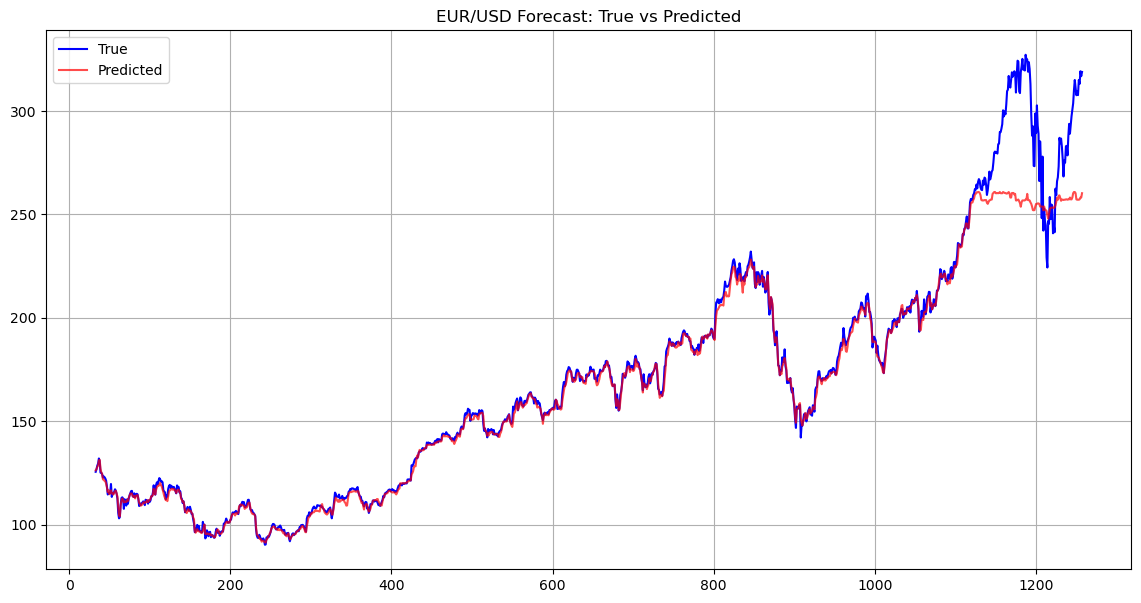

In [ ]:
# Create a new DataFrame for visualization
viz_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})

# Concatenate the training data for a complete view
viz_df_train = pd.DataFrame({'True': y_train, 'Predicted': y_train_pred})
viz_df = pd.concat([viz_df_train, viz_df])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(viz_df['True'], label='True', color='blue')
plt.plot(viz_df['Predicted'], label='Predicted', color='red', alpha=0.7)
plt.title('EUR/USD Forecast: True vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

## Using external data from YFinance API

In [ ]:
! python -m pip install yfinance

     -------------------------------------- 69.0/69.0 kB 625.2 kB/s eta 0:00:00
     ---------------------------------------- 62.6/62.6 kB 1.7 MB/s eta 0:00:00
     -------------------------------------- 502.5/502.5 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 2.9/2.9 MB 2.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     -------------------------------------- 112.2/112.2 kB 2.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.0-py3-none-any.whl size=135766 sha256=74a7e0af1c0e3502cb7de02d86d042530a3e04a1a1c237231d3442ee856d913e
  Stored in directory: c:\users\inesj\appdata\local\pip\cache\wheels\77\6b\dc\722aee2a5d46a021ab67564c9d3d5536c3bd9577fc

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.31.0 which is incompatible.


In [ ]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,...,trend_macd,trend_macd_signal,trend_macd_diff,volatility_bbm,volatility_bbl,volatility_bbh,trend_psar,momentum_stoch,momentum_stoch_signal,Close_Lag1
33,AAPL,2015-07-14,125.61,126.37,125.04,126.04,31768139,115.752554,116.452912,115.227286,...,-1.328825,-1.369099,0.040273,125.91275,121.997475,129.828025,126.237969,60.396975,53.213611,125.66
34,AAPL,2015-07-15,126.82,127.15,125.58,125.72,33649200,116.867598,117.171700,115.724909,...,-1.085016,-1.312282,0.227266,125.87375,122.011296,129.736204,120.070000,76.152305,65.806282,125.61
35,AAPL,2015-07-16,128.51,128.57,127.35,127.74,36222447,118.424972,118.480264,117.356005,...,-0.746818,-1.199189,0.452371,125.93425,121.948396,129.920104,120.205000,99.358289,78.635856,126.82
36,AAPL,2015-07-17,129.62,129.62,128.31,129.08,46164710,119.447863,119.447863,118.240668,...,-0.384790,-1.036309,0.651519,126.02125,121.800288,130.242212,120.537200,100.000000,91.836864,128.51
37,AAPL,2015-07-20,132.07,132.97,130.70,130.97,58900203,121.705596,122.534967,120.443109,...,0.098677,-0.809312,0.907989,126.29475,121.318025,131.271475,121.082168,93.454545,97.604278,129.62


In [ ]:
import yfinance as yf

df = yf.download("AAPL", start="2010-01-01", end="2023-01-01")
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478996,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490201,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386964,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375158,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417542,447610800


In [ ]:
# Plotting price against date
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], linewidth=2, color='b', label='close')
plt.xlabel('Date')
plt.ylabel('close')
plt.title('close variation over time')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'data' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2010-01-04 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3272 non-null   float64
 1   High       3272 non-null   float64
 2   Low        3272 non-null   float64
 3   Close      3272 non-null   float64
 4   Adj Close  3272 non-null   float64
 5   Volume     3272 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 178.9 KB


In [ ]:
# Compute RSI
df['momentum_rsi'] = RSIIndicator(close=df['Close']).rsi()

# Compute MACD
macd = MACD(close=df['Close'])
df['trend_macd'] = macd.macd()
df['trend_macd_signal'] = macd.macd_signal()
df['trend_macd_diff'] = macd.macd_diff()

# Compute Bollinger Bands
bollinger = BollingerBands(close=df['Close'])
df['volatility_bbm'] = bollinger.bollinger_mavg()
df['volatility_bbl'] = bollinger.bollinger_lband()
df['volatility_bbh'] = bollinger.bollinger_hband()

# Compute Parabolic SAR
psar = PSARIndicator(high=df['Close'], low=df['Close'], close=df['Close'])  # Assuming you have 'High' and 'Low' columns in your df
df['trend_psar'] = psar.psar()


# Compute Stochastic Oscillator
stochastic = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'])  # Assuming you have 'High' and 'Low' columns
df['momentum_stoch'] = stochastic.stoch()
df['momentum_stoch_signal'] = stochastic.stoch_signal()

# Create Lag Features
df['Close_Lag1'] = df['Close'].shift(1)

# Drop NaN values introduced due to lag features and indicators
df = df.dropna()

# Define features and target
X = df[['momentum_rsi', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'volatility_bbm', 'volatility_bbl', 'volatility_bbh', 'trend_psar', 'momentum_stoch', 'momentum_stoch_signal', 'Close_Lag1']]
y = df['Close']

In [ ]:
# Splitting TS data into train and test set for model training and testing
train_ts = df.iloc[0:2700,]
test_ts = df.iloc[2700: ,]

In [ ]:
train_ts.head()

,Open,High,Low,Close,Adj Close,Volume,momentum_rsi,trend_macd,trend_macd_signal,trend_macd_diff,volatility_bbm,volatility_bbl,volatility_bbh,trend_psar,momentum_stoch,momentum_stoch_signal,Close_Lag1
Date,,,,,,,,,,,,,,,,,
2010-02-22,7.226429,7.232143,7.113929,7.157857,6.067570,390563600,47.617442,-0.052874,-0.094309,0.041435,7.108964,6.795130,7.422799,6.874317,71.099519,80.556902,7.202500
2010-02-23,7.142857,7.190357,6.989643,7.037857,5.965851,575094800,43.102673,-0.058240,-0.087095,0.028856,7.098232,6.790138,7.406327,6.881780,46.136716,65.874178,7.157857
2010-02-24,7.079643,7.194286,7.065714,7.166429,6.074838,460566400,48.713452,-0.051523,-0.079981,0.028458,7.088804,6.801905,7.375702,6.889095,72.882718,63.372984,7.037857
2010-02-25,7.049286,7.245000,7.031786,7.214286,6.115404,665126000,50.663657,-0.041856,-0.072356,0.030500,7.078304,6.828285,7.328322,6.896263,82.838061,67.285832,7.166429
2010-02-26,7.227857,7.327500,7.214286,7.307857,6.194724,507460800,54.321085,-0.026341,-0.063153,0.036812,7.087821,6.818789,7.356854,6.903287,95.076104,83.598961,7.214286


In [ ]:
# Define features and target for the training set
X_train = train_ts[['trend_macd_diff', 'volatility_bbm', 'volatility_bbl', 'volatility_bbh', 'trend_psar', 'momentum_stoch_signal', 'Close_Lag1']]
y_train = train_ts['Close']
# Define features and target for the testing set
X_test = test_ts[['trend_macd_diff', 'volatility_bbm', 'volatility_bbl', 'volatility_bbh', 'trend_psar', 'momentum_stoch_signal', 'Close_Lag1']]
y_test = test_ts['Close']

In [ ]:
# Initialize the model
model = xgb.XGBRegressor(
    learning_rate=0.75,
    n_estimators=400,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    gamma=0,
    min_child_weight=1
)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.75, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

y_train_pred = model.predict(X_train)

Mean Absolute Error: 23.853773141836193
Mean Squared Error: 816.0865331858237
Root Mean Squared Error: 28.567228307727433


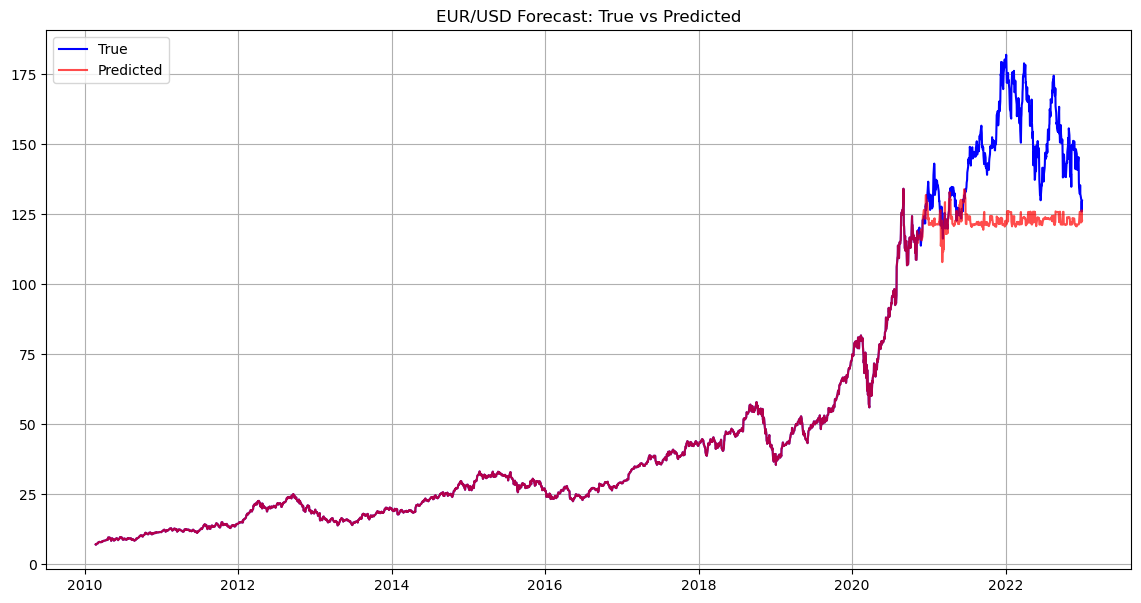

In [ ]:
# Create a new DataFrame for visualization
viz_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})

# Concatenate the training data for a complete view
viz_df_train = pd.DataFrame({'True': y_train, 'Predicted': y_train_pred})
viz_df = pd.concat([viz_df_train, viz_df])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(viz_df['True'], label='True', color='blue')
plt.plot(viz_df['Predicted'], label='Predicted', color='red', alpha=0.7)
plt.title('EUR/USD Forecast: True vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 400,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2023-12-30 17:24:53,457] A new study created in memory with name: no-name-6fbc77ce-bfad-4d26-9675-1087925fd794
[I 2023-12-30 17:24:54,514] Trial 0 finished with value: 81.20935632715549 and parameters: {'learning_rate': 0.0027306664696252225, 'max_depth': 8, 'subsample': 0.4302646124904116, 'colsample_bytree': 0.05582595403726765, 'min_child_weight': 19}. Best is trial 0 with value: 81.20935632715549.
[I 2023-12-30 17:24:55,231] Trial 1 finished with value: 52.081862759409304 and parameters: {'learning_rate': 0.004973291124834872, 'max_depth': 2, 'subsample': 0.8088627300293799, 'colsample_bytree': 0.467919831283543, 'min_child_weight': 14}. Best is trial 1 with value: 52.081862759409304.
[I 2023-12-30 17:24:56,565] Trial 2 finished with value: 39.39620027329789 and parameters: {'learning_rate': 0.0065288319913889455, 'max_depth': 6, 'subsample': 0.6809303907597474, 'colsample_bytree': 0.7887087918043141, 'min_child_weight': 7}. Best is trial 2 with value: 39.39620027329789.
[I 2023

[I 2023-12-30 17:25:24,685] Trial 28 finished with value: 27.443542394426718 and parameters: {'learning_rate': 0.06146370959668795, 'max_depth': 2, 'subsample': 0.5122063918340032, 'colsample_bytree': 0.7774466516126035, 'min_child_weight': 9}. Best is trial 24 with value: 26.300160909945205.
[I 2023-12-30 17:25:25,313] Trial 29 finished with value: 31.406183709491415 and parameters: {'learning_rate': 0.0628227886813661, 'max_depth': 1, 'subsample': 0.41294930384796047, 'colsample_bytree': 0.9025187361633341, 'min_child_weight': 20}. Best is trial 24 with value: 26.300160909945205.


In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.06750958942092945, 'max_depth': 1, 'subsample': 0.38921778597341394, 'colsample_bytree': 0.905611989224628, 'min_child_weight': 2}
Best RMSE: 26.300160909945205


In [ ]:
# Initialize the model
model = xgb.XGBRegressor(
    **study.best_params
)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.905611989224628, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06750958942092945,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

y_train_pred = model.predict(X_train)

Mean Absolute Error: 32.077775831346386
Mean Squared Error: 1290.848022918911
Root Mean Squared Error: 35.928373507840725


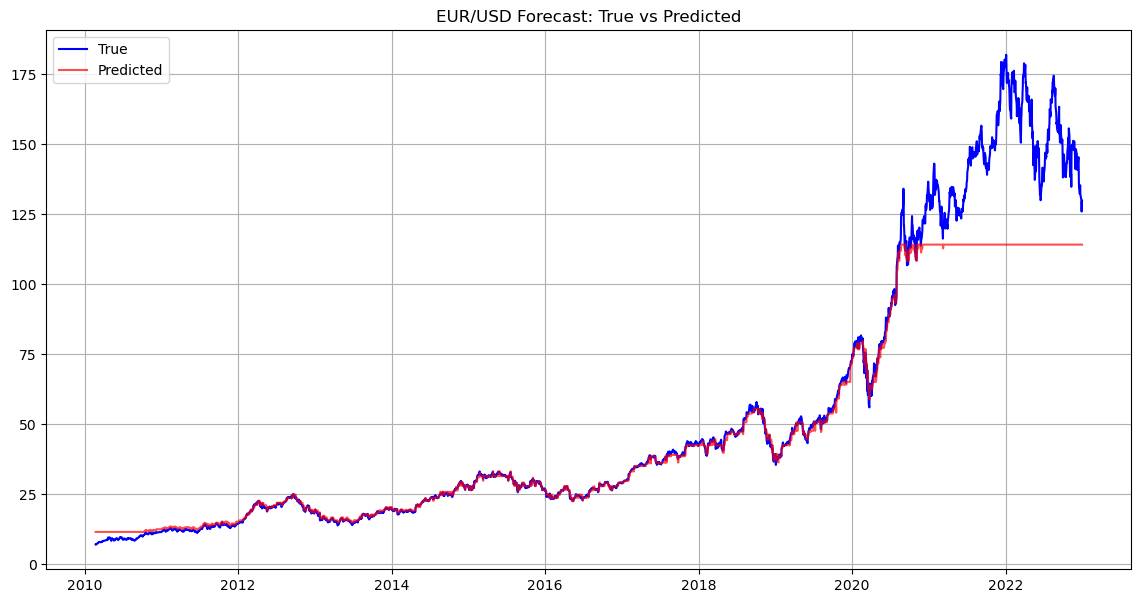

In [ ]:
# Create a new DataFrame for visualization
viz_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})

# Concatenate the training data for a complete view
viz_df_train = pd.DataFrame({'True': y_train, 'Predicted': y_train_pred})
viz_df = pd.concat([viz_df_train, viz_df])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(viz_df['True'], label='True', color='blue')
plt.plot(viz_df['Predicted'], label='Predicted', color='red', alpha=0.7)
plt.title('EUR/USD Forecast: True vs Predicted')
plt.legend()
plt.grid(True)
plt.show()